## Exploratory Data Analysis / Feature Extraction

In [1]:
from os import walk
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
import IPython.display as ipd
import matplotlib.pyplot as plt

In [2]:
# parse the file names into a numpy matrix, each row represents one file.
RAW_DATA_PATH = '../data/raw'
dirs = []
for (dirpath, dirnames, _) in walk(RAW_DATA_PATH):
    for d in dirnames:
        if d.startswith("Actor"):
            dirs.append(dirpath+'/'+d)
    break
    
all_files = []
for actor in dirs:
    for(_,_,files) in walk(actor):
        all_files+=[i.split('.')[0].split('-') for i in files]
        break
all_files = [[int(i) - 1 for i in row] for row in all_files]

files = np.array(all_files)
print(files)

[[ 2  0  0 ...  0  0  0]
 [ 2  0  0 ...  0  1  0]
 [ 2  0  0 ...  1  0  0]
 ...
 [ 2  0  7 ...  0  1 23]
 [ 2  0  7 ...  1  0 23]
 [ 2  0  7 ...  1  1 23]]


In [3]:
def matrix_to_filename(matrix, RAW_DATA_PATH):
    filepaths = []
    for row in matrix:
        filename = ''
        for col in row:
            filename+=str(col+1).zfill(2)
            filename+='-'
        filename = filename[:-1]
        filename+='.wav'
        filepaths.append(RAW_DATA_PATH+'/Actor_'+str(row[6]+1).zfill(2)+'/'+filename)
        # print(filename)
    return filepaths
def plot_counts(files):
    print(f"Total number of files {files.shape[0]}")

    labels = [['full-AV', 'video-only', 'audio-only'],
             ['speech', 'song'],
             ['neutral' , 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust','surprised'],
             ['normal', 'strong'],
             ['Kids are talking by the door', 'Dogs are sitting by the door'],
             ['1st repetition', '2nd repetition'],
             ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24']
             ]
    titles = ['Modality', 'Vocal channel', 'Emotion', 'Emotional intensity' ,'Statement','Repetition' ,'Actor']
    
    fig, ax = plt.subplots(2, 4, figsize=(20, 10)) 
    inds = [(0,0), (0,1), (0,2), (0,3), (1,0), (1,1), (1,2), (1,3)]
    for i in range(7):
        unique, counts = np.unique(files[:, i], return_counts = True)
        unique = np.array(labels[i])[unique]
        ax[inds[i]].bar(unique, counts)
        ax[inds[i]].set_title(titles[i])
    ax[inds[-1]].axis('off')
    plt.suptitle("Count Plots")
    plt.tight_layout()
    plt.show()

Total number of files 1440


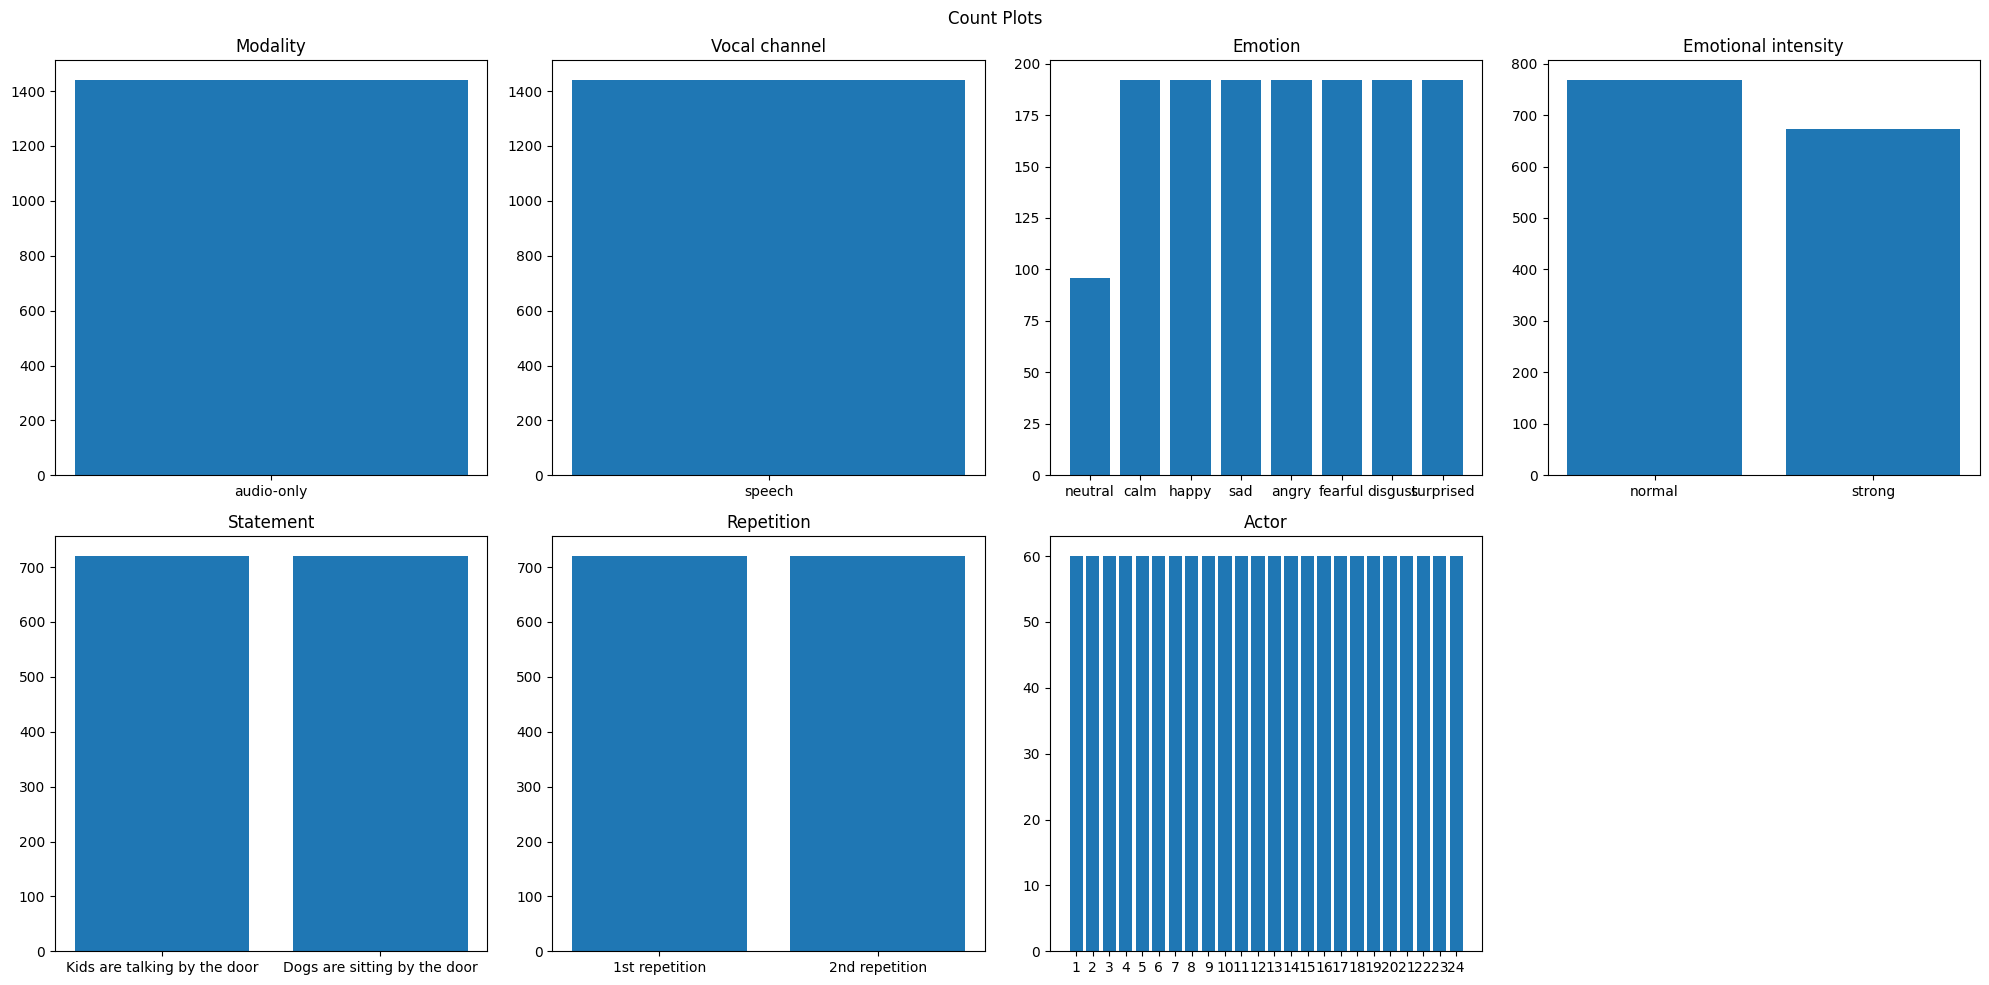

In [4]:
plot_counts(files)

Total number of files 96


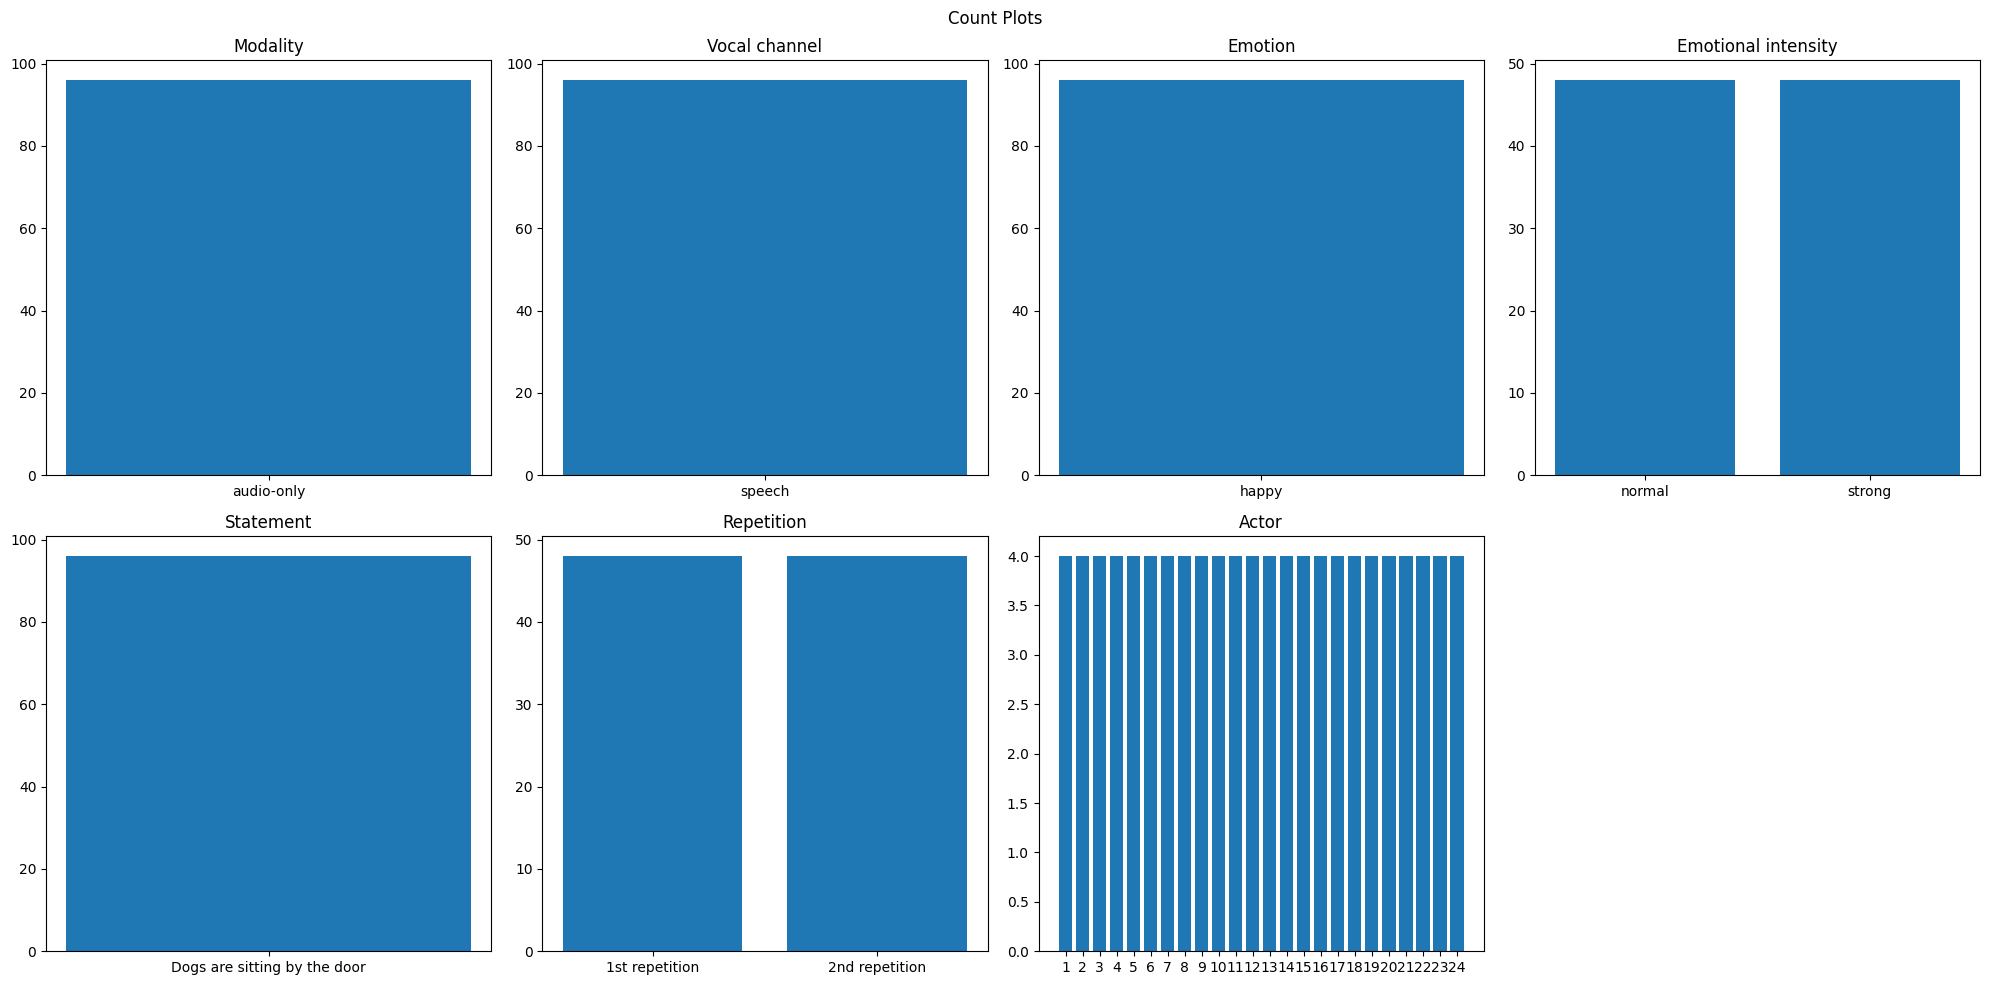

In [5]:
# plot only happy files with "dogs are sitting by the door"
mask = (files[:, 2] == 2 )
mask2 = (files[:, 4] == 1 )
extracted = files[mask&mask2]
plot_counts(extracted)

In [7]:
# average audio of all happy saying "dogs are sitting by the door"
import librosa 
import librosa.display
import IPython.display as ipd

filepaths = matrix_to_filename(extracted, RAW_DATA_PATH)
all_samples = []
for file in filepaths:
    samples, sample_rate = librosa.load(file, sr=None)
    all_samples.append(samples)

mn = min(len(row) for row in all_samples)
print(mn)

truncated_data = [row[:mn] for row in all_samples]
average_audio = np.mean(np.array(truncated_data), axis = 0)
ipd.Audio(data=average_audio, rate=48000)

150551


### Mel-Frequency Cepstral Coefficients (MFCC) - Short term power spectrum of sound, divides frequencies based on mel scale over time. 

The way we percieve pitch is non-linear so we have much better resolution at lower frequencies than at high frequencies.

We perceive frequency logarithmically

Mel spectrograms provide perceptually-relevant frequency representation
Mel Scale: perceptually relevant scale for pitch (Frequency (Hz) vs Mel freq (Mels)), meaning equal frequency distances on the scale have the same "perceptual distance"

In [29]:
import IPython.display as ipd

audio_file = r"C:\Users\acts5\OneDrive\Audio_Sentiment_Analysis\Audio-Sentiment-Analysis\data\raw\Actor_01\03-01-01-01-01-01-01.wav"  # string path
ipd.Audio(audio_file)


In [30]:
signal, sr = librosa.load(audio_file)
signal.shape

(72838,)

In [31]:
#Extract MFCCs
mfccs = librosa.feature.mfcc(y=signal, n_mfcc = 13, sr = sr)
mfccs.shape

(13, 143)

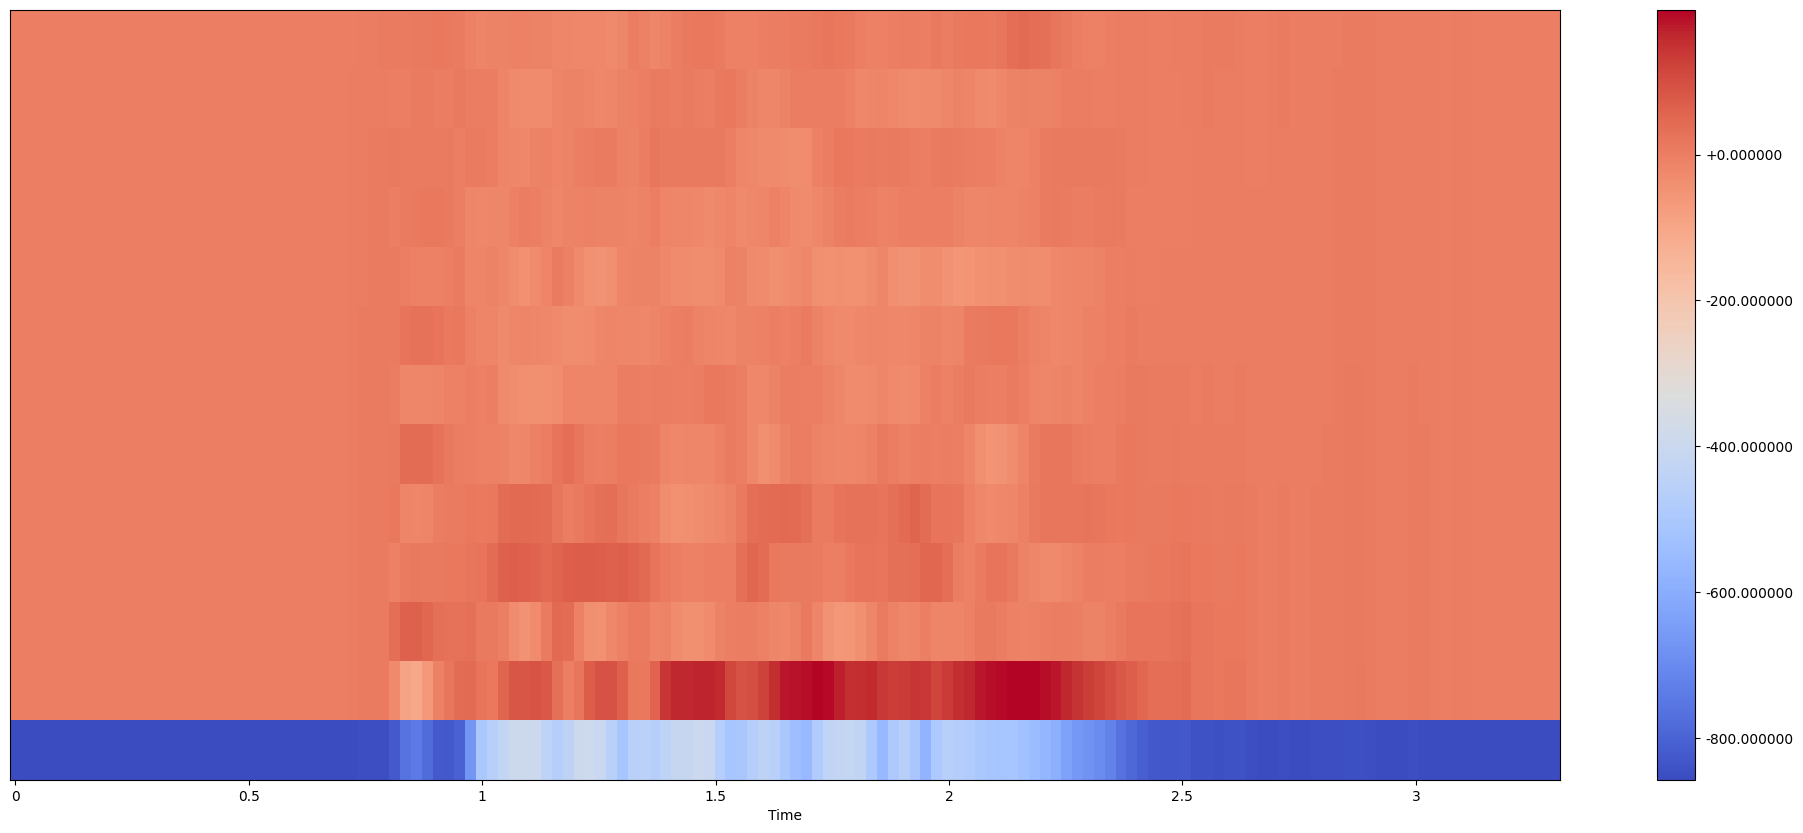

In [32]:
#Visualize MFCCs
plt.figure(figsize = (25, 10))
librosa.display.specshow(mfccs,
                         x_axis = "time",
                         sr=sr)
plt.colorbar(format = "%+2f")
plt.show()

Calculate mfcc's 1st and 2nd derivs to learn how the mfcc's change over time in the audio file

In [33]:
#Calculate delta and delta2 MFCCs

delta_mfccs = librosa.feature.delta(mfccs)
delta2_mfccs = librosa.feature.delta(mfccs, order=2)

print(delta_mfccs.shape)
print(mfccs.shape)

(13, 143)
(13, 143)


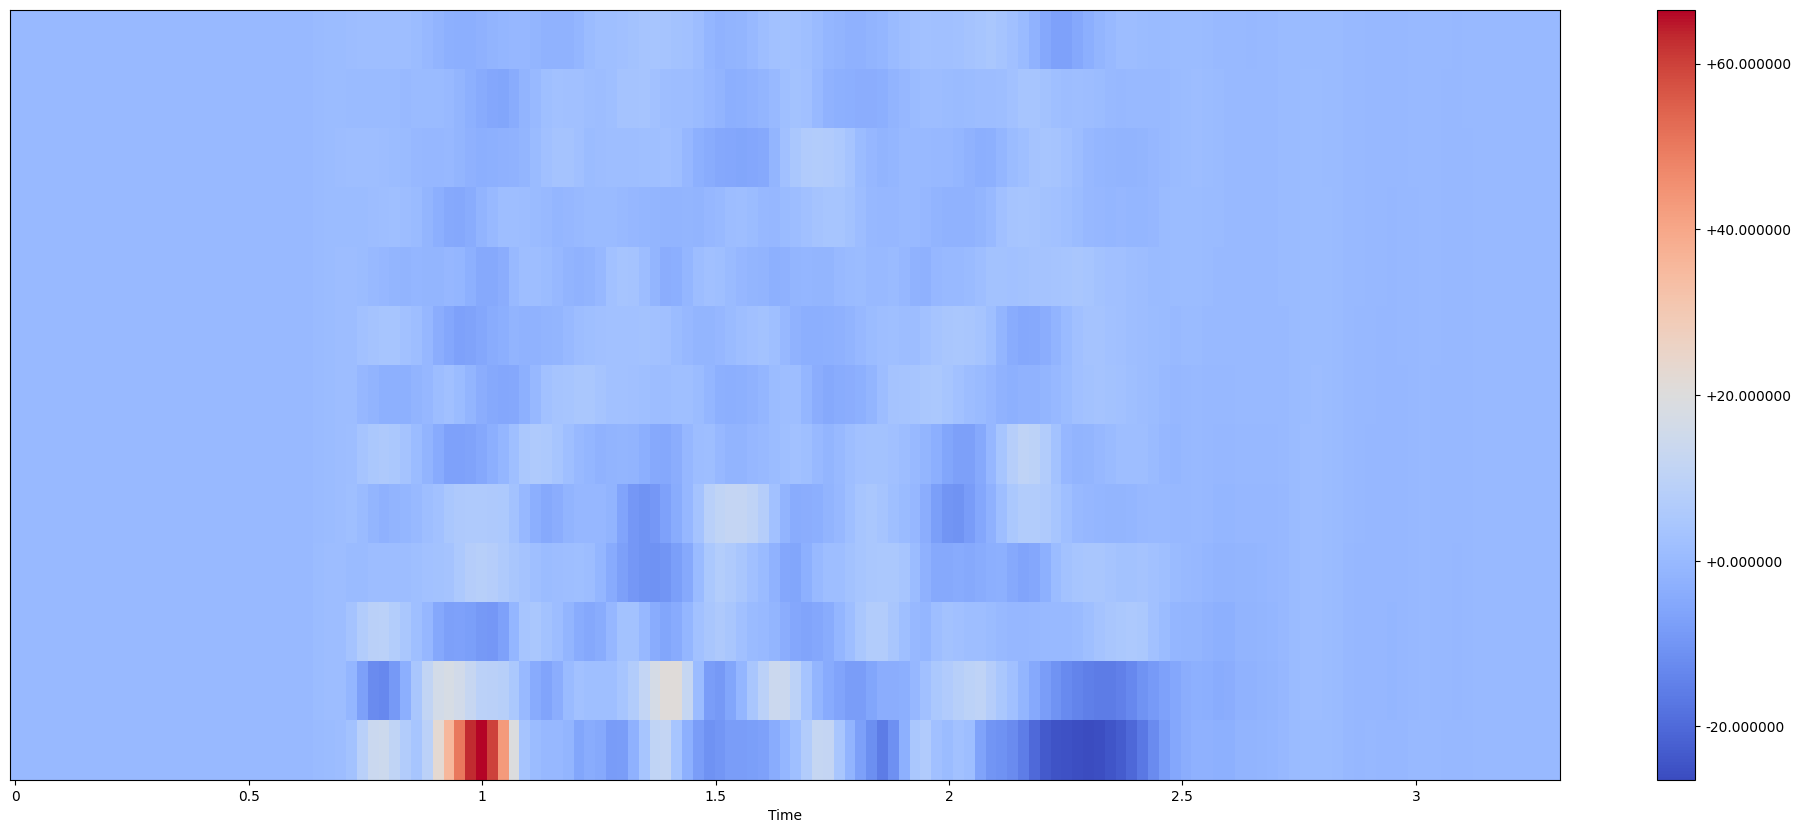

In [34]:
#Visualize delta_mfccs
plt.figure(figsize = (25, 10))
librosa.display.specshow(delta_mfccs,
                         x_axis = "time",
                         sr=sr)
plt.colorbar(format = "%+2f")
plt.show()

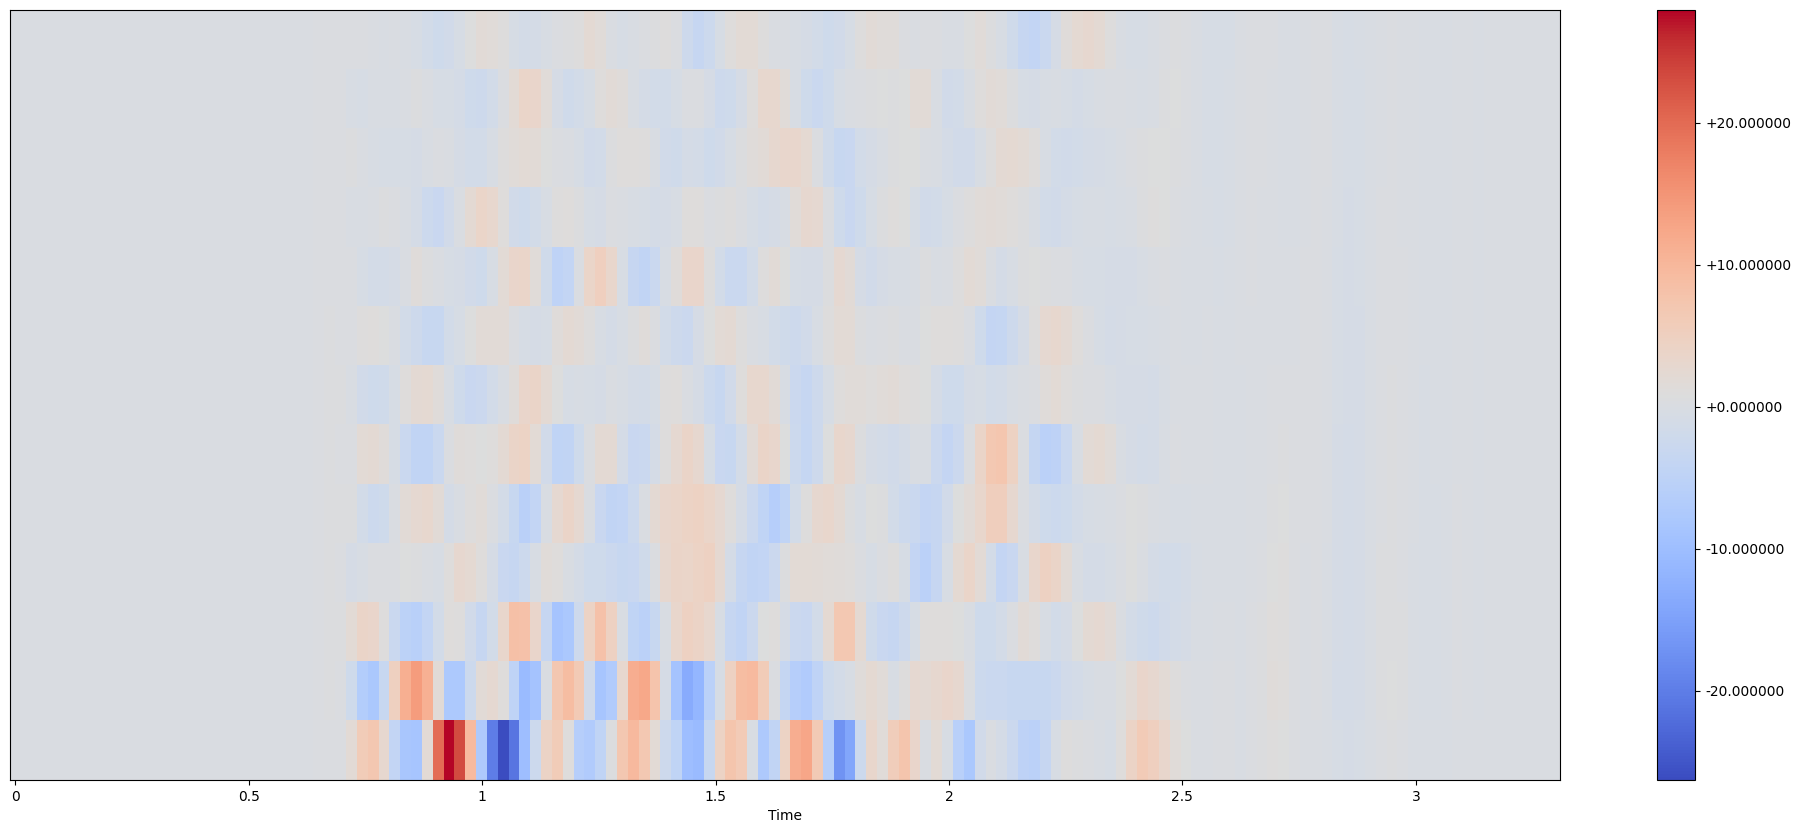

In [35]:
#Visualize delta2_mfccs
plt.figure(figsize = (25, 10))
librosa.display.specshow(delta2_mfccs,
                         x_axis = "time",
                         sr=sr)
plt.colorbar(format = "%+2f")
plt.show()

**Take mfcc's, their 1st and 2nd derivatives, and concatenate them together so that we can have a unique audio feature regarding the mfcc's.**

In [36]:
comprehensive_mfccs = np.concatenate((mfccs, delta_mfccs, delta2_mfccs))
comprehensive_mfccs.shape

(39, 143)

## MFCC Feature Extraction

In [45]:
print(filepaths)

['../data/raw/Actor_01/03-01-03-01-02-01-01.wav', '../data/raw/Actor_01/03-01-03-01-02-02-01.wav', '../data/raw/Actor_01/03-01-03-02-02-01-01.wav', '../data/raw/Actor_01/03-01-03-02-02-02-01.wav', '../data/raw/Actor_02/03-01-03-01-02-01-02.wav', '../data/raw/Actor_02/03-01-03-01-02-02-02.wav', '../data/raw/Actor_02/03-01-03-02-02-01-02.wav', '../data/raw/Actor_02/03-01-03-02-02-02-02.wav', '../data/raw/Actor_03/03-01-03-01-02-01-03.wav', '../data/raw/Actor_03/03-01-03-01-02-02-03.wav', '../data/raw/Actor_03/03-01-03-02-02-01-03.wav', '../data/raw/Actor_03/03-01-03-02-02-02-03.wav', '../data/raw/Actor_04/03-01-03-01-02-01-04.wav', '../data/raw/Actor_04/03-01-03-01-02-02-04.wav', '../data/raw/Actor_04/03-01-03-02-02-01-04.wav', '../data/raw/Actor_04/03-01-03-02-02-02-04.wav', '../data/raw/Actor_05/03-01-03-01-02-01-05.wav', '../data/raw/Actor_05/03-01-03-01-02-02-05.wav', '../data/raw/Actor_05/03-01-03-02-02-01-05.wav', '../data/raw/Actor_05/03-01-03-02-02-02-05.wav', '../data/raw/Actor_

In [51]:
def feature_extraction(file_path): #give filepath
    #load the audio file
    x, sr = librosa.load(file_path)
    #extract audio features
    mfcc = np.mean(librosa.feature.mfcc(y=x, sr=sr,n_mfcc=13).T, axis=0)

    return mfcc

First, I created a dictionary holding arrays for each audio file containing 50 MFCC's per file. Then, I converted it to a 2d NumPy array for ease of use. Each row is a feature vector for 1 audio file, currently containing 13 columns (each entry is a MFCC)

In [52]:
features = {}
for index, audio in enumerate(filepaths):
    features[index] = feature_extraction(audio)
print(features[0])

X = np.array(list(features.values()))
print(X.shape)  # should be (num_files, 50)

[-6.5622888e+02  6.2206532e+01 -2.3432081e+00  1.2916070e+01
  1.8241282e+00 -1.7071337e-01 -5.6699905e+00 -7.2867751e+00
 -1.3776975e+01 -3.3122015e+00  2.3617578e+00 -7.0014296e+00
  1.9307775e+00]
(96, 13)


In [53]:
#MFCC feature vector for audio file 0...  50 total MFCC coefficients per audio
features[0], len(features[0])

(array([-6.5622888e+02,  6.2206532e+01, -2.3432081e+00,  1.2916070e+01,
         1.8241282e+00, -1.7071337e-01, -5.6699905e+00, -7.2867751e+00,
        -1.3776975e+01, -3.3122015e+00,  2.3617578e+00, -7.0014296e+00,
         1.9307775e+00], dtype=float32),
 13)